In [ ]:
from pathlib import Path

ROOT = Path(".")  # you're inside Project 3
OUT = ROOT / "outputs"
FIG = OUT / "figures"
TAB = OUT / "tables"
FIG.mkdir(parents=True, exist_ok=True)
TAB.mkdir(parents=True, exist_ok=True)

print("Outputs:", OUT.resolve())

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_raw(path):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    return df

raw245 = load_raw("ssp245.csv")
raw585 = load_raw("ssp585.csv")

print("Columns:", raw245.columns.tolist())
print("Unique locations (sample):", raw245["Location"].dropna().unique()[:20])
print("n locations:", raw245["Location"].nunique())

Columns: ['Unnamed: 0', 'X.1', 'X', 'Lat', 'Lon', 'Year', 'Week', 'W', 'Temp', 'Location', 'Cpool']
Unique locations (sample): ['Härnösand' 'Luleå' 'Malmö']
n locations: 3


In [2]:
def filter_location(df, wanted=("Luleå","Lulea","Luleaa")):
    out = df[df["Location"].isin(wanted)].copy()
    if out.empty:
        # fallback: case-insensitive contains
        out = df[df["Location"].astype(str).str.lower().str.contains("lule")].copy()
    return out

l245 = filter_location(raw245)
l585 = filter_location(raw585)

print("Rows in Luleå (ssp245):", len(l245))
print("Rows in Luleå (ssp585):", len(l585))
print("Locations kept:", l245["Location"].unique())
l245.head()

Rows in Luleå (ssp245): 4558
Rows in Luleå (ssp585): 4558
Locations kept: ['Luleå']


,Unnamed: 0,X.1,X,Lat,Lon,Year,Week,W,Temp,Location,Cpool
53,9117,9117,9117,65.621823,21.95548,2015,1,0.914534,-14.776029,Luleå,1.009127
54,9118,9118,9118,65.621823,21.95548,2015,2,0.893549,-15.382171,Luleå,1.036823
55,9119,9119,9119,65.621823,21.95548,2015,3,0.877240,-6.528257,Luleå,1.001133
56,9120,9120,9120,65.621823,21.95548,2015,4,0.867597,-9.234229,Luleå,0.938878
57,9121,9121,9121,65.621823,21.95548,2015,5,0.876409,-5.982771,Luleå,0.871603


Convert Year+Week → datetime (weekly time axis)

In [4]:
def add_week_time(df):
    df = df.copy()
    # Monday of ISO week
    iso = (
        df["Year"].astype(int).astype(str)
        + "-W"
        + df["Week"].astype(int).astype(str).str.zfill(2)
        + "-1"
    )
    df["time"] = pd.to_datetime(iso, format="%G-W%V-%u")
    return df.sort_values("time").reset_index(drop=True)

l245 = add_week_time(l245)
l585 = add_week_time(l585)

# Kelvin -> Celsius if needed
for d in (l245, l585):
    if d["Temp"].median() > 100:
        d["Temp"] = d["Temp"] - 273.15

print(l245[["time","Year","Week","Temp","Location"]].head())
print("Year range:", l245["time"].dt.year.min(), "-", l245["time"].dt.year.max())

        time  Year  Week       Temp Location
0 2014-12-29  2015     1 -14.776029    Luleå
1 2015-01-05  2015     2 -15.382171    Luleå
2 2015-01-12  2015     3  -6.528257    Luleå
3 2015-01-19  2015     4  -9.234229    Luleå
4 2015-01-26  2015     5  -5.982771    Luleå
Year range: 2014 - 2101


first plot: annual mean temperature (SSP245 vs SSP585)

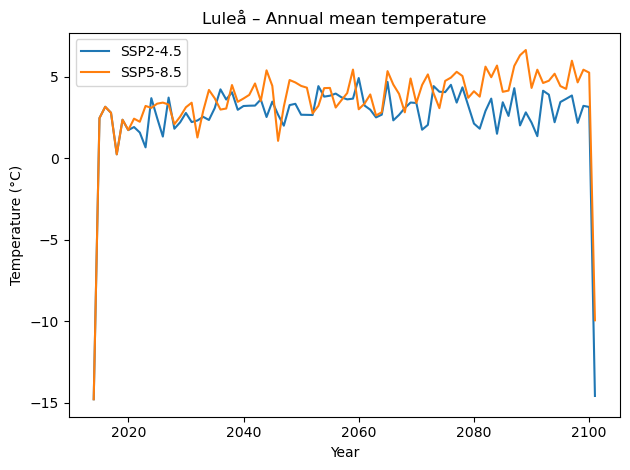

In [5]:
def annual_mean(df):
    out = df.copy()
    out["year"] = out["time"].dt.year
    return out.groupby("year", as_index=False)["Temp"].mean()

ann245 = annual_mean(l245)
ann585 = annual_mean(l585)

plt.figure()
plt.plot(ann245["year"], ann245["Temp"], label="SSP2-4.5")
plt.plot(ann585["year"], ann585["Temp"], label="SSP5-8.5")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Luleå – Annual mean temperature")
plt.legend()
plt.tight_layout()
plt.show()

It already matches the “hockey stick / annual timeseries” idea from the inspiration deck.

But there’s one clear problem in your figure:

✅ The huge drop at ~2100 is almost certainly a data artifact

That “cliff” at the very end (down to ~ −15°C) is usually caused by:
	•	an incomplete final year (only a few weeks present), or
	•	a bad/missing-value code that got averaged in, or
	•	week parsing issues for the last entries.

So before we do harvest-time, we should clean the annual series so your results are defensible.

### Fix the end-of-series artifact (filter out incomplete years)


In [8]:
def annual_mean_with_counts(df):
    tmp = df.copy()
    tmp["Year"] = tmp["time"].dt.year
    g = tmp.groupby("Year").agg(
        temp_mean=("Temp", "mean"),
        n_weeks=("Temp", "count")
    ).reset_index()
    return g

ann245c = annual_mean_with_counts(l245)
ann585c = annual_mean_with_counts(l585)

print("SSP245 weeks per year (min/max):", ann245c["n_weeks"].min(), ann245c["n_weeks"].max())
print("SSP585 weeks per year (min/max):", ann585c["n_weeks"].min(), ann585c["n_weeks"].max())

# Keep only "complete-ish" years (>= 50 weeks)
ann245_clean = ann245c[ann245c["n_weeks"] >= 50].copy()
ann585_clean = ann585c[ann585c["n_weeks"] >= 50].copy()

ann245_clean.head(), ann245_clean.tail()

SSP245 weeks per year (min/max): 1 55
SSP585 weeks per year (min/max): 1 55


(   Year  temp_mean  n_weeks
 1  2015   2.472488       52
 2  2016   3.164999       52
 3  2017   2.797495       53
 4  2018   0.249637       55
 5  2019   2.369700       53,
     Year  temp_mean  n_weeks
 82  2096   3.652394       55
 83  2097   3.856735       53
 84  2098   2.178476       53
 85  2099   3.222210       52
 86  2100   3.154623       52)

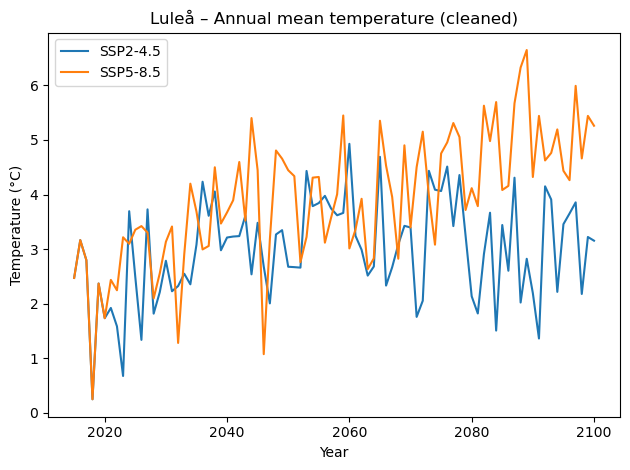

In [9]:
plt.figure()
plt.plot(ann245_clean["Year"], ann245_clean["temp_mean"], label="SSP2-4.5")
plt.plot(ann585_clean["Year"], ann585_clean["temp_mean"], label="SSP5-8.5")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Luleå – Annual mean temperature (cleaned)")
plt.legend()
plt.tight_layout()
plt.show()

#### Now we can compute a better growth proxy than annual mean temp

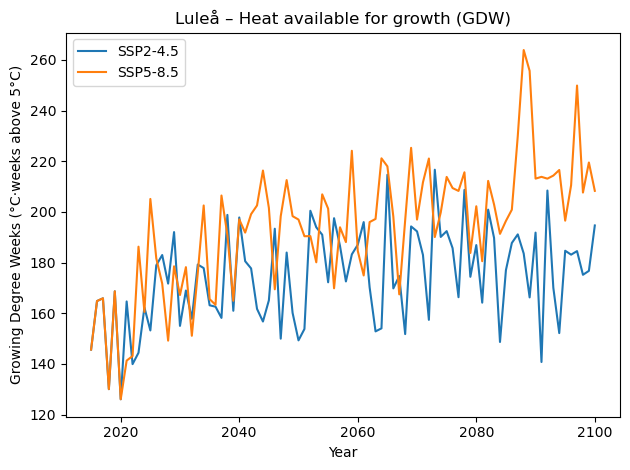

In [10]:
TBASE = 5.0  # growth threshold (°C), tweakable

def annual_growing_degree_weeks(df, tbase=TBASE):
    tmp = df.copy()
    tmp["Year"] = tmp["time"].dt.year
    tmp["gdw"] = np.maximum(tmp["Temp"] - tbase, 0.0)
    out = tmp.groupby("Year").agg(
        gdw=("gdw", "sum"),
        n_weeks=("gdw", "count")
    ).reset_index()
    return out

gdw245 = annual_growing_degree_weeks(l245)
gdw585 = annual_growing_degree_weeks(l585)

# clean incomplete years
gdw245 = gdw245[gdw245["n_weeks"] >= 50].copy()
gdw585 = gdw585[gdw585["n_weeks"] >= 50].copy()

plt.figure()
plt.plot(gdw245["Year"], gdw245["gdw"], label="SSP2-4.5")
plt.plot(gdw585["Year"], gdw585["gdw"], label="SSP5-8.5")
plt.xlabel("Year")
plt.ylabel("Growing Degree Weeks (°C·weeks above 5°C)")
plt.title("Luleå – Heat available for growth (GDW)")
plt.legend()
plt.tight_layout()
plt.show()

### Convert GDW into “years to harvest” (calibrated to 6 years in baseline)

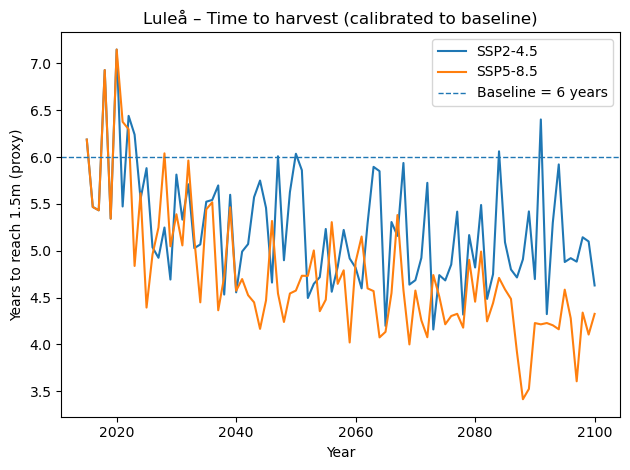

In [11]:
TARGET_HEIGHT = 1.5
BASELINE_YEARS = 6
BASE_START, BASE_END = 2015, 2020

def years_to_harvest_from_gdw(gdw_df):
    df = gdw_df.copy()

    base = df[(df["Year"] >= BASE_START) & (df["Year"] <= BASE_END)]
    if base.empty:
        raise ValueError("Baseline 2015–2020 not present after cleaning. Print year range and adjust baseline.")
    gdw_base = float(base["gdw"].mean())
    if gdw_base <= 1e-9:
        raise ValueError("Baseline GDW is ~0; lower TBASE.")

    # Calibrate: baseline should imply 1.5m in 6y
    k = TARGET_HEIGHT / (BASELINE_YEARS * gdw_base)   # m per (°C·week)

    df["height_rate"] = k * df["gdw"]                 # m/year (proxy)
    df["years_to_1p5m"] = TARGET_HEIGHT / df["height_rate"]
    return df

harv245 = years_to_harvest_from_gdw(gdw245)
harv585 = years_to_harvest_from_gdw(gdw585)

plt.figure()
plt.plot(harv245["Year"], harv245["years_to_1p5m"], label="SSP2-4.5")
plt.plot(harv585["Year"], harv585["years_to_1p5m"], label="SSP5-8.5")
plt.axhline(BASELINE_YEARS, linestyle="--", linewidth=1, label="Baseline = 6 years")
plt.xlabel("Year")
plt.ylabel("Years to reach 1.5m (proxy)")
plt.title("Luleå – Time to harvest (calibrated to baseline)")
plt.legend()
plt.tight_layout()
plt.show()